In [1]:
import base64
import os
import pandas as pd
from PIL import Image
from openai import OpenAI
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# Function to encode image to base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [3]:
# Setup OpenAI API client
load_dotenv('.env', override=True)
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [4]:
# Function to classify an image using GPT-4o
def classify_image_gpt4o(image_path, client):
    base64_image = encode_image(image_path)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "You are an expert assistant trained to classify a person's state into one of the following categories: 'alert' or 'drowsy'. Yawning is considered drowsy. Base your classification on the person’s facial expressions such as mouth and eyes. Provide only the class name as your response (one word ONLY)."
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Classify the person's state in this image."},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ]
            }
        ],
        temperature=0.0
    )

    return response.choices[0].message.content.strip().lower().replace(".", "")

In [5]:
# Function to evaluate GPT-4o on test set
def evaluate_model_on_dataset_gpt4o(root_dir, client):
    test_folder = os.path.join(root_dir, "test")
    csv_files = [f for f in os.listdir(test_folder) if f.endswith("_classes.csv")]
    assert len(csv_files) == 1, "Expected one _classes.csv file in the test folder."

    csv_path = os.path.join(test_folder, csv_files[0])
    df = pd.read_csv(csv_path)

    label_mapping = {"alert": 0, "drowsy": 1}
    inverse_label_mapping = {v: k for k, v in label_mapping.items()}

    all_labels = []
    all_preds = []

    for _, row in df.iterrows():
        filename = row["filename"]
        label = "drowsy" if row["1"] == 1 else "alert"
        image_path = os.path.join(test_folder, filename)

        if not os.path.isfile(image_path):
            print(f"Missing file: {image_path}, skipping.")
            continue

        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            print(f"Unsupported file type: {filename}, skipping.")
            continue

        # Predict with GPT-4o
        predicted_label = classify_image_gpt4o(image_path, client)

        if predicted_label not in label_mapping:
            print(f"Unexpected model output '{predicted_label}' for {filename}, skipping.")
            continue

        all_labels.append(label_mapping[label])
        all_preds.append(label_mapping[predicted_label])

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["alert", "drowsy"]))

    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["alert", "drowsy"], yticklabels=["alert", "drowsy"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix on Test Dataset")
    plt.tight_layout()
    plt.show()

Accuracy: 0.8154
Precision: 0.9189
Recall: 0.8154
F1 Score: 0.8438

Classification Report:
              precision    recall  f1-score   support

       alert       0.39      0.95      0.55        58
      drowsy       0.99      0.80      0.88       424

    accuracy                           0.82       482
   macro avg       0.69      0.87      0.72       482
weighted avg       0.92      0.82      0.84       482



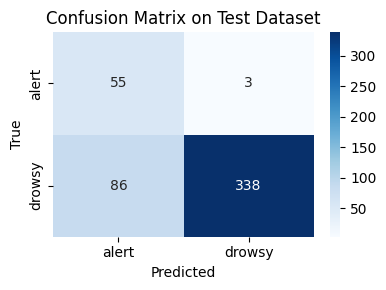

In [6]:
# Run the evaluation
dataset_dir = "./Drowsiness-/-Fatigue_Detection-4"
evaluate_model_on_dataset_gpt4o(dataset_dir, client)